# Прогнозирование стоимости покупки подержанного автомобиля

**Содержание:**  
1. [Импорт данных и общая информация](#load_and_info)  
 1.1. [Импорт библиотек](#import)  
 1.2. [Импорт данных](#read)  
 1.3. [Общая информация](#info)  
    
    
2. [Предобработка данных](#preparation_analisys)  

3. [Исследовательский анализ данных](#analisys)

4. [Разработка модели ML](#ML)  
 4.1. [Подготовка данных](#data_preparation)  
 4.2. [Построение модели прогнозирования](#build_models)  
 4.3. [Предсказание на тестовой выборке](#pred_test)  
 
 
5. [Оценка значимости признаков](#significance)  

6. [Общий вывод](#final)  

**Заказчик исследования:** сеть отелей.  
**Цель исследования:** разработка и обучение ML-модели прогнозирования стоимости подержанного автомобиля и определение признаков, оказывающих наибольшее влияние на цену.

**Исходные данные:**  
Исходные данные представлены в датасетах:
- train.csv — обучающая выборка;
- test.csv — тестовая выборка.

В датасетах содержатся следующие признаки:  
- 'year' - год производства;
- 'condition' - состояние по шкале (1-5);
- 'make' - производитель;
- 'odometer' - пробег в милях;
- 'model' - модель;
- 'color' - цвет кузова;
- 'trim' - модификация;
- 'interior' - цвет интерьера;
- 'body' - тип кузова;
- 'seller' - продавец;
- 'transmission' - тип КПП;
- 'sellingprice' - стоимость продажи;
- 'vin' - идентификатор (вин);
- 'saledate' - дата продажи;
- 'state' - штат регистрации;

## Импорт данных и общая информация
<a id="load_and_info"></a>

### Импорт библиотек
<a id="import"></a>

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import requests
import seaborn as sns

from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from urllib.parse import urlencode

### Импорт данных
<a id="read"></a>

In [2]:
def read_table(linc):
    '''функция загрузки таблиц по ссылке'''
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = linc

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    pd.read_csv(download_url) 
    return pd.read_csv(download_url)

In [3]:
try:
    df_train = read_table('https://disk.yandex.ru/d/fiWbGsGFgvGtog')
except:
    df_train = pd.read_csv('train.csv')
    
try:
    df_test = read_table('https://disk.yandex.ru/d/4R_ZeJtz7Ooa5Q')
except:
    df_test = pd.read_csv('test.csv')

pd.set_option('display.max_columns', None)

### Общая информация
<a id="info"></a>

Функция вывода общей информации:

In [4]:
def inf(df_tmp):
    '''функция получения общей информации'''
    print('Размер датафрейма:')
    print(df_tmp.shape)
    print('_' * 50)
    print()
    print('Общая информация о датафрейме:')
    print(df_tmp.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Несколько строк датафрейма:')
    display(df_tmp.sample(random_state=0, n=5))
    print('_' * 50)
    print()
    print('Количество полных дубликатов:')
    print(df_tmp.duplicated().sum())
    print('_' * 50)  
    if 'vin' in df_tmp.columns:
        print()
        print('Количество дубликатов без учета поля идентификатора:')
        print(df_tmp.drop(columns=['vin']).duplicated().sum())
        print('_' * 50)  
    print()
    print('Описательная статистика строковых значений:')
    display(df_tmp.describe(include=['object']).T)
    print('_' * 50)
    print()
    print('Описательная статистика числовых значений:')
    display(df_tmp.describe().T)
    print('_' * 50)
    print()
    print('Количество пропусков:')
    print(df_tmp.isna().sum())
    print()
    print('Количество пропусков в процентах:')
    print(df_tmp.isna().mean()*100)  

Общая информация по обучающим данным:

In [5]:
inf(df_train)

Размер датафрейма:
(440236, 15)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
29256,2014,BMW,3 Series,328i xDrive SULEV,Sedan,automatic,wba3b5g54ens10954,oh,4.2,2223.0,—,black,bmw na manheim new jersey,37500,Tue Jan 27 2015 06:00:00 GMT-0800 (PST)
107420,2013,Lexus,CT 200h,Base,hatchback,automatic,jthkd5bhxd2154964,ca,2.5,12002.0,—,tan,high bid trading co inc,18000,Wed Jun 03 2015 05:15:00 GMT-0700 (PDT)
417721,2003,Mercedes-Benz,C-Class,C240 4MATIC,Sedan,automatic,wdbrf81j43f401613,nc,3.0,151715.0,black,black,credit acceptance corp/vrs/southfield,2400,Mon Jan 12 2015 00:00:00 GMT-0800 (PST)
143756,2013,Hyundai,Sonata,GLS,Sedan,automatic,5npeb4ac9dh683308,mi,4.6,51606.0,white,beige,dtg operations inc,11300,Thu Feb 12 2015 01:30:00 GMT-0800 (PST)
266550,2004,Ford,Focus,ZTS,Sedan,automatic,1fafp38z04w200363,tx,2.0,117489.0,gray,—,unlimited auto finance group,1200,Tue May 05 2015 02:15:00 GMT-0700 (PDT)


__________________________________________________

Количество полных дубликатов:
0
__________________________________________________

Количество дубликатов без учета поля идентификатора:
0
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
make,432193,92,Ford,73708
model,432113,959,Altima,15454
trim,431899,1922,Base,43853
body,429843,85,Sedan,157639
transmission,388775,2,automatic,375061
vin,440236,440236,2fmdk3jc4bba41556,1
state,440236,38,fl,65618
color,439650,20,black,87115
interior,439650,17,black,192442
seller,440236,13025,nissan-infiniti lt,15823


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
year,440236.0,2010.040101,3.977945,1982.0,2007.0,2012.0,2013.0,2015.0
condition,430831.0,3.425077,0.949973,1.0,2.7,3.6,4.2,5.0
odometer,440167.0,68344.421604,53542.203908,1.0,28258.0,52098.0,99272.0,999999.0
sellingprice,440236.0,13592.209588,9751.479098,1.0,6900.0,12100.0,18200.0,230000.0


__________________________________________________

Количество пропусков:
year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

Количество пропусков в процентах:
year             0.000000
make             1.826975
model            1.845147
trim             1.893757
body             2.360779
transmission    11.689412
vin              0.000000
state            0.000000
condition        2.136354
odometer         0.015673
color            0.133110
interior         0.133110
seller           0.000000
sellingprice     0.000000
saledate         0.000000
dtype: float64


Общая информация по тестовым данным:

In [6]:
inf(df_test)

Размер датафрейма:
(110060, 14)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110060 non-null  int64  
 1   make          107999 non-null  object 
 2   model         107981 non-null  object 
 3   trim          107946 non-null  object 
 4   body          107466 non-null  object 
 5   transmission  97048 non-null   object 
 6   vin           110060 non-null  object 
 7   state         110060 non-null  object 
 8   condition     107681 non-null  float64
 9   odometer      110041 non-null  float64
 10  color         109902 non-null  object 
 11  interior      109902 non-null  object 
 12  seller        110060 non-null  object 
 13  saledate      110060 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 80.6 MB
None
__

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
30257,2013,Nissan,Altima,2.5 S,Coupe,automatic,1n4al2ep4dc153469,ga,3.7,56097.0,gray,black,the hertz corporation,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
90584,2014,Nissan,NV Cargo,2500 S,Van,automatic,1n6bf0lyxen100980,pa,3.5,38828.0,white,gray,exceptional motorcars ltd,Wed Feb 18 2015 01:30:00 GMT-0800 (PST)
37119,2015,Ford,Taurus,Limited,sedan,automatic,1fahp2f81fg104879,ne,4.0,17603.0,gray,black,enterprise vehicle exchange/davenport,Thu Jun 04 2015 03:30:00 GMT-0700 (PDT)
86069,2010,Chevrolet,Silverado 1500,LT,Crew Cab,automatic,3gcrcse06ag218007,tx,2.9,111333.0,black,brown,alamo city autoplex,Wed Feb 18 2015 02:00:00 GMT-0800 (PST)
37324,2005,Ford,Freestyle,SE,Wagon,automatic,1fmdk01165ga81292,nj,2.5,118248.0,gray,gray,wells fargo dealer services,Wed Mar 04 2015 01:30:00 GMT-0800 (PST)


__________________________________________________

Количество полных дубликатов:
0
__________________________________________________

Количество дубликатов без учета поля идентификатора:
0
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
make,107999,85,Ford,18384
model,107981,824,Altima,3736
trim,107946,1496,Base,11007
body,107466,77,Sedan,39255
transmission,97048,2,automatic,93585
vin,110060,110060,1g6dp567450124779,1
state,110060,38,fl,16295
color,109902,20,black,22006
interior,109902,17,black,48176
seller,110060,7623,"ford motor credit company,llc",3858


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
year,110060.0,2010.059904,3.960432,1982.0,2007.0,2012.0,2013.0,2015.0
condition,107681.0,3.423206,0.951323,1.0,2.7,3.6,4.2,5.0
odometer,110041.0,68075.693541,53523.551837,1.0,28314.0,51922.0,98854.0,999999.0


__________________________________________________

Количество пропусков:
year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13012
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

Количество пропусков в процентах:
year             0.000000
make             1.872615
model            1.888970
trim             1.920770
body             2.356896
transmission    11.822642
vin              0.000000
state            0.000000
condition        2.161548
odometer         0.017263
color            0.143558
interior         0.143558
seller           0.000000
saledate         0.000000
dtype: float64


**Вывод:**
1. В обучающей выборке 440236 строк и 15 признаков, в тестовой выборке 110060 строк и 14 признаков.
2. В полях make, model, trim, body, transmission, condition, odometer, color, interior присутствуют пропущенные значения.
2. Следующие признаки имеют тип int64:  
 - year;  
 - sellingprice.
 
 Следующие признаки имеют тип object:   
  - make;
  - model; 
  - trim; 
  - body; 
  - transmission; 
  - vin; 
  - state; 
  - color; 
  - interior; 
  - seller; 
  - saledate.   

 Следующие признаки имеют тип float64:  
  - condition;
  - odometer.

## Предобработка данных
<a id="preparation_analisys"></a>

Создаем список датафреймов:

In [7]:
df_list = [df_train, df_test]

Приводим текстовые значения к нижнему регистру и обрабатываем пропущенные значения:

In [8]:
def preprocessing(df):
    # Список текстовых признаков
    text_list = ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior', 'seller']
    # Список числовых признаков
    numeric_list = ['condition', 'odometer']
    
    
    for i in text_list:                                                # Проходим циклом по списку текстовых признаков 
        df[i] = (
            df[i]
            .astype({i : 'str'})
            .apply(lambda x: x.lower())                                # Переводим символы в нижний регистр 
            .fillna('no available')                                    # Заменяем пропуски на 'no available'
            .replace({'nan': 'no available', '—': 'no available'})     # Заменяем пропуски на 'no available'
        )
    
    for i in numeric_list:                                             # Проходим циклом по списку числовых значений
        for j in df['model'].unique():                                 # Проходим циклом по уникальным значениям "model"
            for k in df['year'].unique():                              # Проходим циклом по уникальным значениям "year"
                # заменяем пропуски числовых признаков на средние значения
                df.loc[(df[i].isna()) & (df['model'] == j) & (df['year'] == k), i] =\
                df.loc[(df['model'] == j)  & (df['year'] == k)][i].mean()
                
    for i in df['model'].unique():                                     # Проходим циклом по уникальным значениям "model"
        # заменяем значения 'no available' признаков 'transmission' и 'make' на наиболее часто встречающиеся (в зависимости от модели)
        df.loc[(df['model'] == i) & (df['transmission'] == 'no available'), 'transmission'] =\
        df.loc[(df['model'] == i)]['transmission'].value_counts().idxmax()
        df.loc[(df['model'] == i) & (df['make'] == 'no available'), 'make'] =\
        df.loc[(df['model'] == i)]['make'].value_counts().idxmax()
    return df

In [9]:
for i in df_list:
    i = preprocessing(i)

Избавляемся от неявных дубликатов в поле "make":

In [10]:
# Словарь соответствий неявных дубликатов
list_make = {'^chev.*':'chevrolet', '^vw':'volkswagen', ' tk':'', 'land.*rover':'landrover', 'mercedes.*':'mercedes'}
df_train['make'] = df_train['make'].replace(list_make, regex=True)          # Замена в датафрейме df_train
df_test['make'] = df_test['make'].replace(list_make, regex=True)            # Замена в датафрейме df_train

Избавляемся от неявных дубликатов в поле "model":

In [11]:
# Словари соответствий неявных дубликатов
model_cadillac = {'^cts.*':'cts', '^escalade .*':'escalade', '^sts.*':'sts'}
model_gmc = {'^envoy .*':'envoy', '^savana .*':'savana', '^sierra .*':'sierra', '^yukon .*':'yukon'}
model_nissan = {'^altima .*':'altima', '^murano .*':'murano', '^nv .*':'nv', '^pathfind.*':'pathfinder',
                '^rogue .*':'rogue', '^versa .*':'versa', '^envoy .*':'envoy', '^savana .*':'savana',
                '^sierra .*':'sierra', '^yukon .*':'yukon'}
model_chevrolet = {'^s-10.*':'s-10', '^astro .*':'astro', '.*avalanche.*':'avalanche', '^c/k .*':'c/k',
                   '^caprice .*':'caprice', '^corvette .*':'corvette', '^express .*':'express',
                   '^impala .*':'impala', '^malibu .*':'malibu',
                   '^s.*10 .*':'s10', '^silverado .*':'silverado', '^tahoe .*':'tahoe', '^trailblazer .*':'trailblazer'}
model_volkswagen = {'.*beetle.*':'beetle', '.*golf.*':'golf', '^jetta .*':'jetta', '^touareg .*':'touareg'}
model_hyundai = {'^elantra .*':'elantra', '^genesis .*':'genesis', '^santa .*':'santa', '^sonata .*':'sonata'}
model_ford = {'^f-150.*':'f150', '^c-max .*':'c-max', '^e-150.*':'e150', '^e-s.*':'e', '^econoline .*':'econoline',
              '^escape .*':'escape', '^expedition .*':'expedition', '^explorer .*':'explorer',
              '^f.*150 .*':'f150', '^f.*250 .*':'f250', '^f.*350 .*':'f350', '^f.*450 .*':'f450',
              '^focus .*':'focus', '^fusion .*':'fusion', '^mustang .*':'mustang', '^taurus .*':'taurus',
              '^transit .*':'transit'}
model_infiniti = {'^ex.*':'ex35', '^g .*':'g', '^g37 .*':'g37', '^q60 .*':'q60'}
model_subaru = {'^impreza .*':'impreza'}
model_bmw = {'^4 series .*':'4 series', '^1.*':'1 series', '^3 series.*':'3 series', '^5 series.*':'5 series',
             '^6 series.*':'6 series', '^750.*':'750', '^activehybrid.*':'activehybrid', '^m6 .*':'m6', '^x5 .*':'x5',
             '^x6 .*':'x6'}
model_mitsubishi = {'^eclipse .*':'eclipse', '^lancer .*':'lancer', '^montero .*':'montero', '^outlander .*':'outlander'}
model_dodge = {'^gr.*':'grand', '^ram.*':'ram', '^sprinter .*':'sprinter'}
model_oldsmobile = {'^cutlass .*':'cutlass', '^eighty-eight .*':'eighty-eight'}
model_pontiac = {'^grand .*':'grand'}
model_acura = {'^tsx .*':'tsx'}
model_honda = {'^accord .*':'accord', '^ridgelin.*':'ridgeline'}
model_toyota = {'^avalon .*':'avalon', '^camry .*':'camry', '^highlander .*':'highlander',
                '^prius .*':'prius'}
model_audi = {'^allroad .*':'allroad'}
model_jeep = {'^grand .*':'grand'}
model_lincoln = {'^mkz .*':'mkz', '^navigator.*':'navigator', '^town .*':'town'}
model_chrysler = {'^300.*':'300', '^town .*':'town', '^twn.*':'town'}
model_ram = {'^c/v .*':'cargo van', '^promaster cargo van.*':'cargo van'}
model_mercury = {'^grand .*':'grand', '^mariner .*':'mariner', '^milan .*':'milan'}
model_lexus = {'^es 300.*':'es 300', '^is 250.*':'is 250', '^is 350.*':'is 350'}
model_saturn = {'^vue .*':'vue', '^l300.*':'l-series'}
model_mazda = {'^3.*':'mazda3', '.*mazda.*3.*':'mazda3', '^626.*':'capella', '^6.*':'mazda6',
               '.*mazda.*6.*':'mazda6', '^b-series.*':'b-series', '.*protege.*':'protege', '^rx.*':'rx'}
model_porsche = {'^cayman.*':'cayman'}
model_hummer = {'^h2.*':'h2', '^h3.*':'h3'}
model_jaguar = {'^xj.*':'xj', '^xk.*':'xk'}
model_suzuki = {'^xl.*7.*':'xl7'}
model_landrover = {'^discovery.*':'discovery', '^range.*':'rangerover'}
model_bentley = {'^continental.*':'continental'}
model_isuzu = {'^rodeo.*':'rodeo'}
model_maserati = {'^granturismo.*':'granturismo'}

# Словарь соответствий значений "make" и названий словарей неявных дубликатов
maker_dict = {'cadillac' : model_cadillac, 'gmc' : model_gmc, 'nissan' : model_nissan, 'chevrolet' : model_chevrolet,
             'volkswagen' : model_volkswagen, 'hyundai' : model_hyundai, 'ford' : model_ford, 'infiniti' : model_infiniti,
             'subaru' : model_subaru, 'bmw' : model_bmw, 'mitsubishi' : model_mitsubishi, 'dodge' : model_dodge,
             'oldsmobile' : model_oldsmobile, 'pontiac' : model_pontiac, 'acura' : model_acura, 'honda' : model_honda,
             'toyota' : model_toyota, 'audi' : model_audi, 'jeep' : model_jeep, 'lincoln' : model_lincoln,
             'chrysler' : model_chrysler, 'ram' : model_ram, 'mercury' : model_mercury, 'lexus' : model_lexus,
             'saturn' : model_saturn, 'mazda' : model_mazda, 'porsche' : model_porsche, 'hummer' : model_hummer,
             'jaguar' : model_jaguar, 'suzuki' : model_suzuki, 'landrover' : model_landrover, 'bentley' : model_bentley,
             'isuzu' : model_isuzu, 'maserati' : model_maserati}

In [12]:
# Проходим циклом по словарь соответствий значений "make" и названий словарей неявных дубликатов 
for key, value in maker_dict.items(): 
    # Производим замены значений
    df_test.loc[df_test['make'] == key, 'model'] = df_test.loc[df_test['make'] == key]['model'].replace(value, regex=True)
    df_train.loc[df_train['make'] == key, 'model'] = df_train.loc[df_train['make'] == key]['model'].replace(value, regex=True)

Определяем номер недели продажи автомобиля:

In [13]:
def sell_date(df):
    df['saledate'] = pd.to_datetime(df['saledate'], utc=True)              # преобразовываем 'saledate' в datetime
    df['week'] = df['saledate'].dt.isocalendar().week.astype('int64')      # определяем номер недели продажи автомобиля
    return df

In [14]:
for i in df_list:
    i = sell_date(i)

C:\Users\bond_\AppData\Local\Temp\ipykernel_19500\1117697136.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['saledate'] = pd.to_datetime(df['saledate'], utc=True)              # преобразовываем 'saledate' в datetime
C:\Users\bond_\AppData\Local\Temp\ipykernel_19500\1117697136.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['saledate'] = pd.to_datetime(df['saledate'], utc=True)              # преобразовываем 'saledate' в datetime


Обрабатываем значения признаков "trim" и "seller": оставляем 30 чаще встречающихся значений, остальные заменяем на "no available":

In [17]:
def modif(df):
    def join_split(mod):
        return ''.join(re.split(r',|-| |\|/|_|!|&|\'|\(|\)|\+|:', mod))

    def repl(mod, i):
        if i in mod:
            return i
        else:
            return mod
        
    for i in ['trim', 'seller']:
        df[i] = df.apply(lambda x: join_split(x[i]), axis=1)
        list_trim = list(df[i].value_counts().reset_index().head(30))
        for j in list_trim:
            if len(j) >= 3:
                df[i] = df.apply(lambda x: repl(x[i], j), axis=1)
        df.loc[~df[i].isin(list_trim), i] = 'no available'
        df[i] = df[i].fillna('no available')
    return df

In [18]:
for i in df_list:
    i = modif(i)

Обработка неявных дубликатов поля "body":

In [19]:
df_train['body'] = df_train['body'].replace({'regular.*cab':'regular cab'})
df_test['body'] = df_test['body'].replace({'regular.*cab':'regular cab'})

На основании поля "saledate" определяем месяц продажи автомобиля:

**Вывод:**  
1. Пропуски текстовых признаков заменены на "no available". Значения текстовых символов переведены в нижний регистр.
2. Пропуски числовых значений заменены срезними значениями признаков в зависимости от года выпуска и модели автомобиля.
3. Пропуски "transmission" заменены на наиболее часто встречающееся значения у соответствующих моделей автомобилей.
4. Обработаны неявные дубликаты признаков "make', "model" и "body".
5. Добавлен признак "week" - номер недели покупки автомобиля.
6. Для признаков "trim" и "seller" оставлено 30 наиболее часто встречающихся значений. Остальные заменены на "no available".

## Исследовательский анализ данных
<a id="analisys"></a>

Строим диаграммы:

In [20]:
df_analysys = pd.concat([df_train, df_test], ignore_index=True)
df_analysys['selection'] = np.where(df_analysys['sellingprice'].isna(), 'test', 'train')
df_analysys = df_analysys.drop(['sellingprice'], axis=1)


In [21]:
def histogr(df):
    analisys_list = df.columns                             # получаем список признаков
    for i in df.drop(['model', 'trim', 'vin', 'seller', 'saledate',
                      'condition', 'odometer', 'selection'], axis=1).columns:
        plt.figure(figsize=(14,8))
        ax = sns.histplot(x=i, data=df, hue='selection', discrete=True)
        ax.set_title(f'Распределение признака {i}\n для обучающей выборки')
        ax.set_ylabel('Количество')
        plt.xticks(rotation=45)
        ax.set_xlabel(i)
        plt.show()

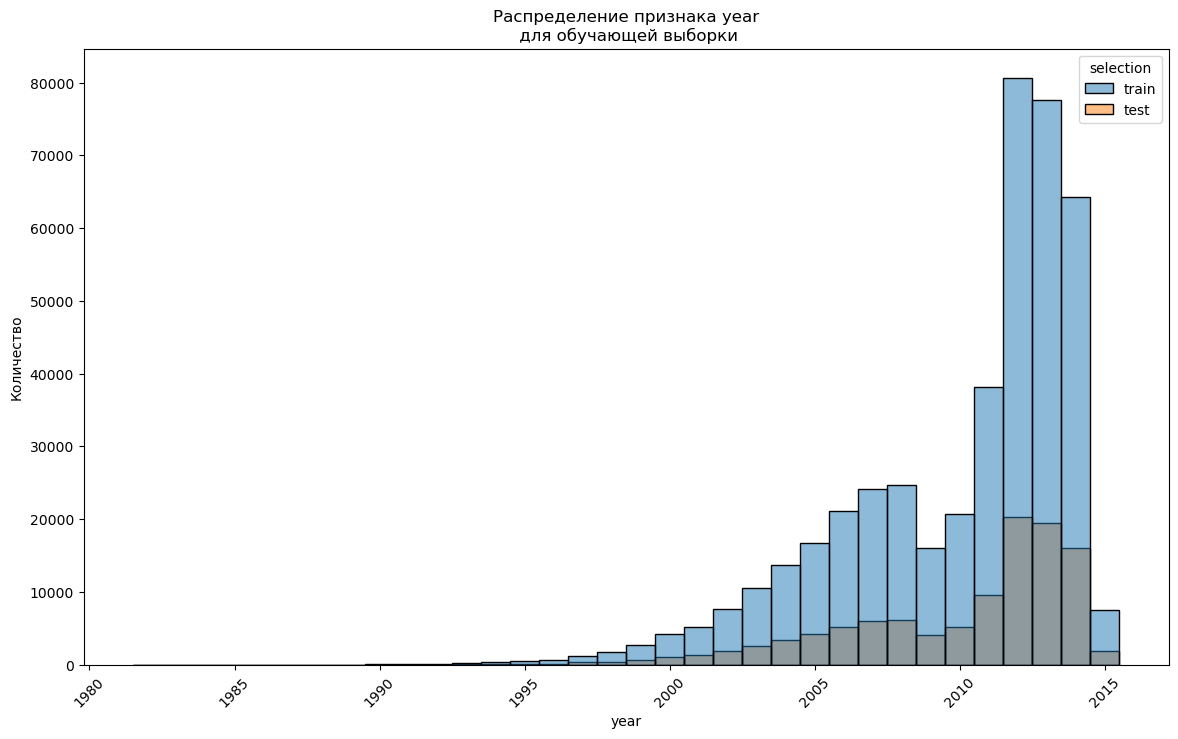

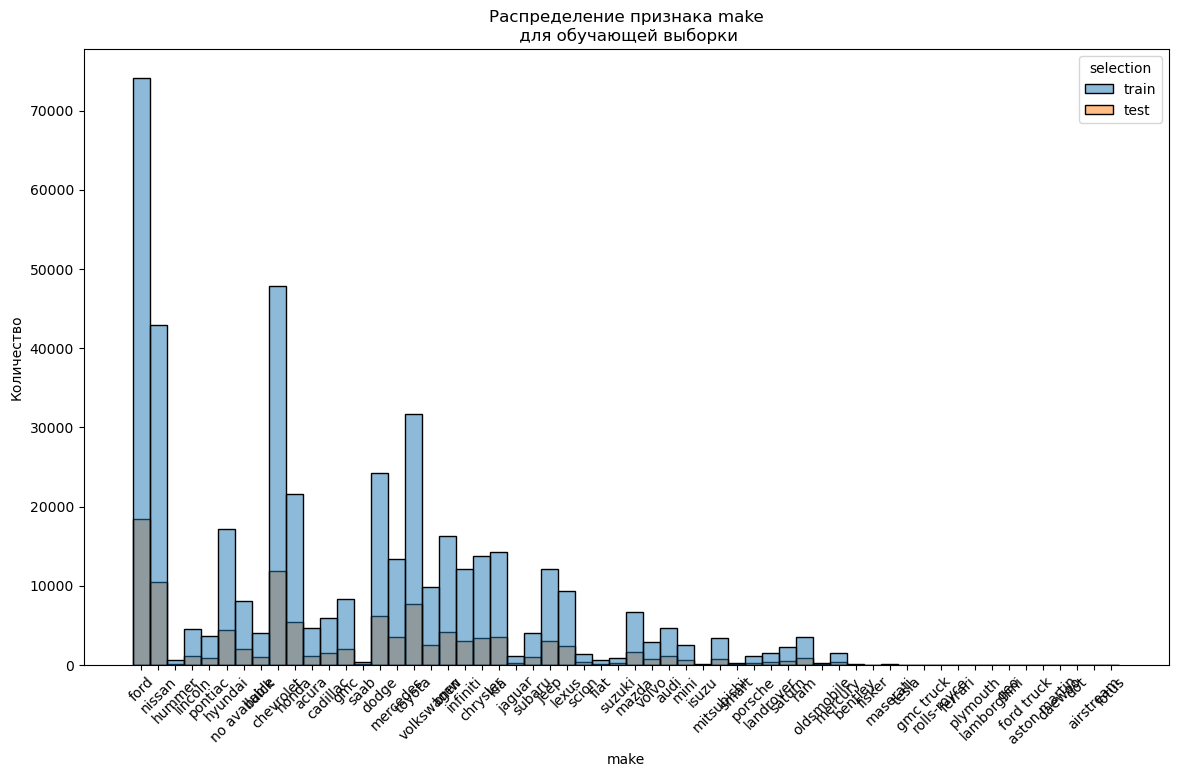

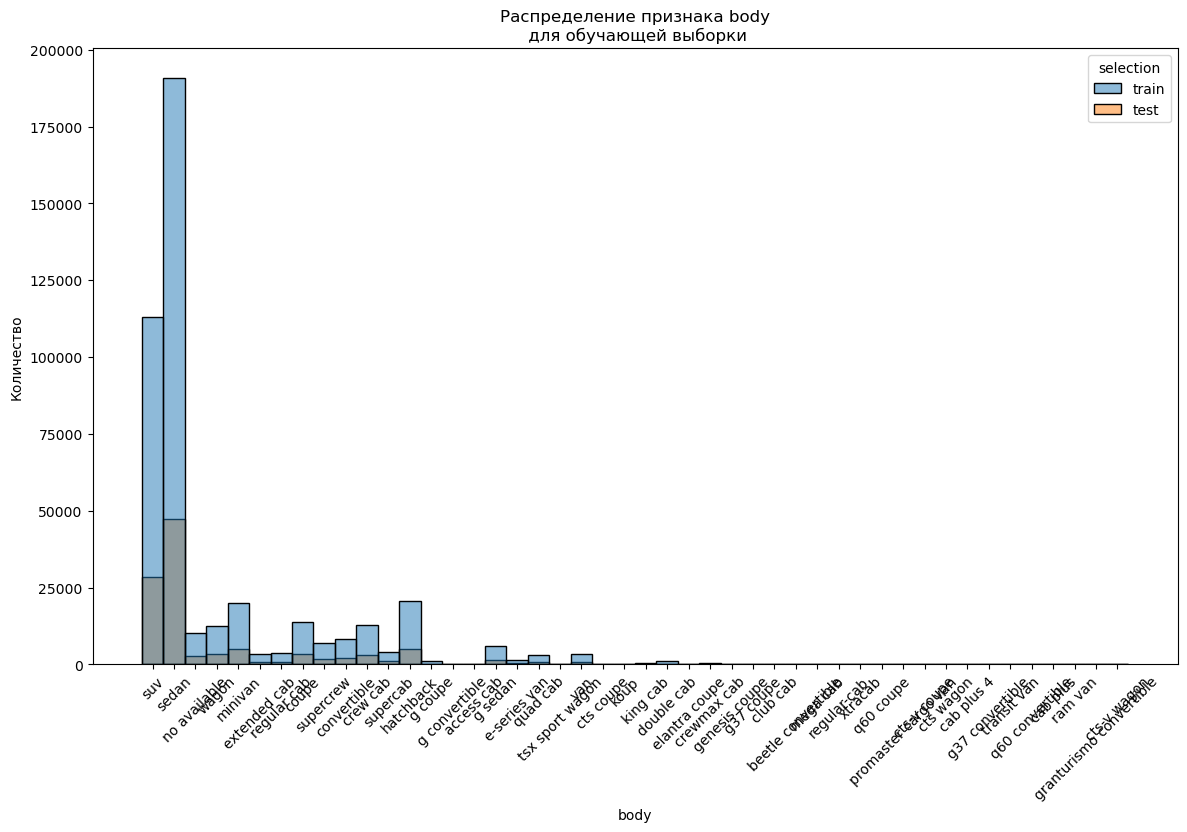

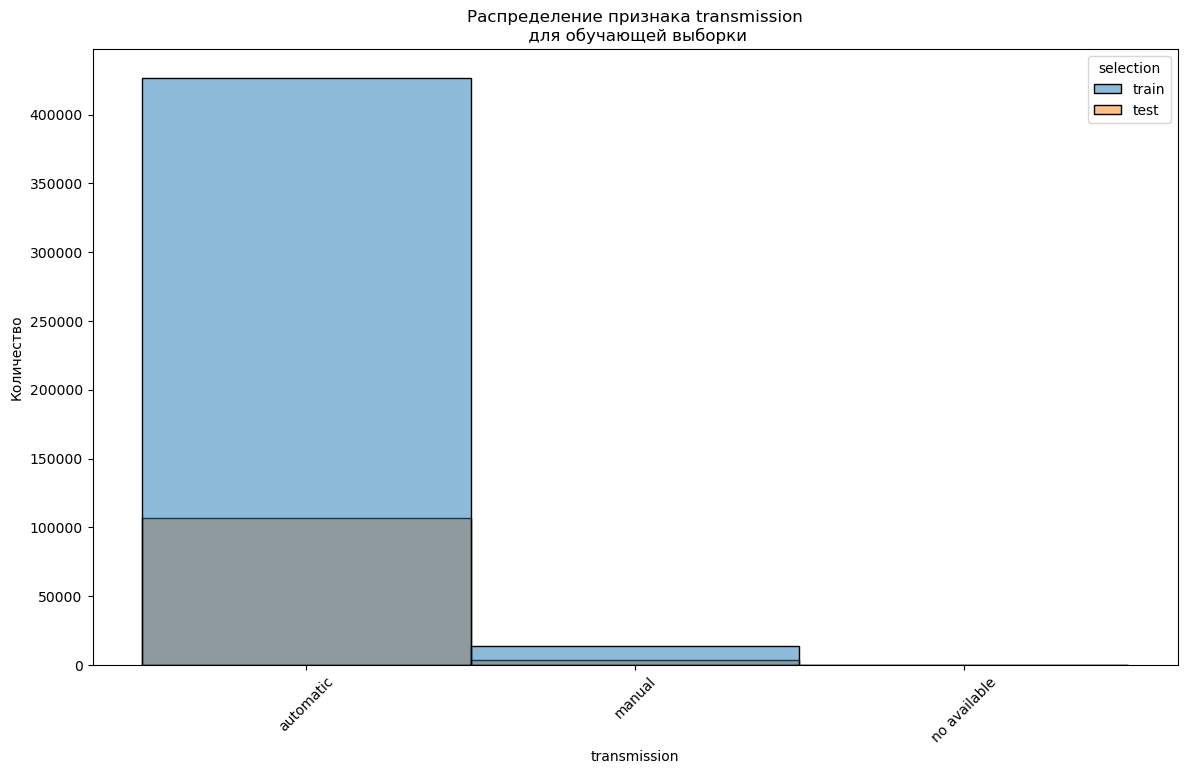

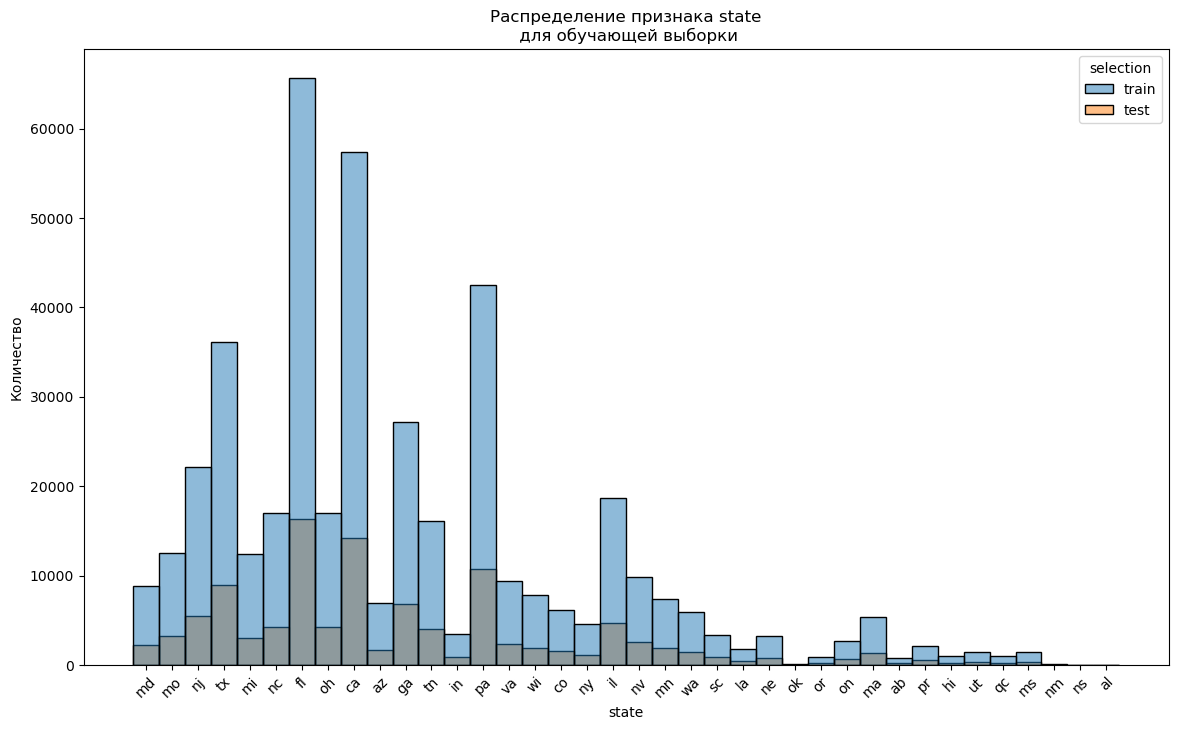

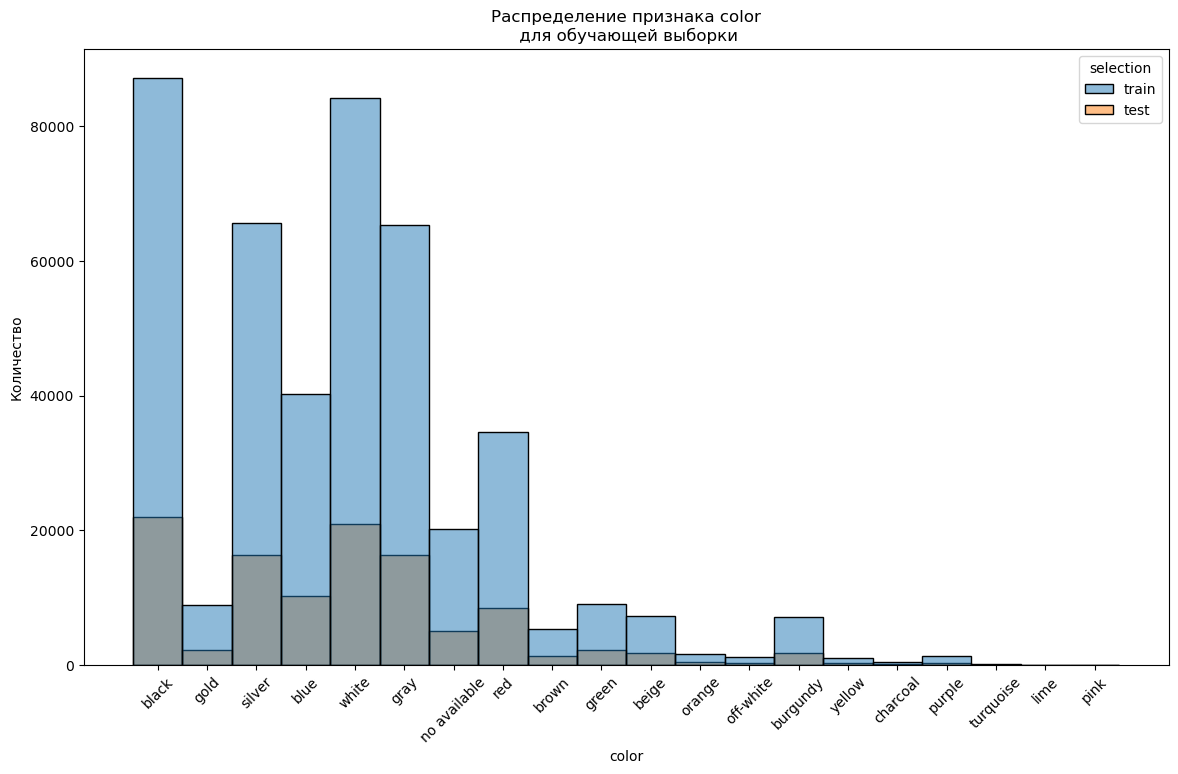

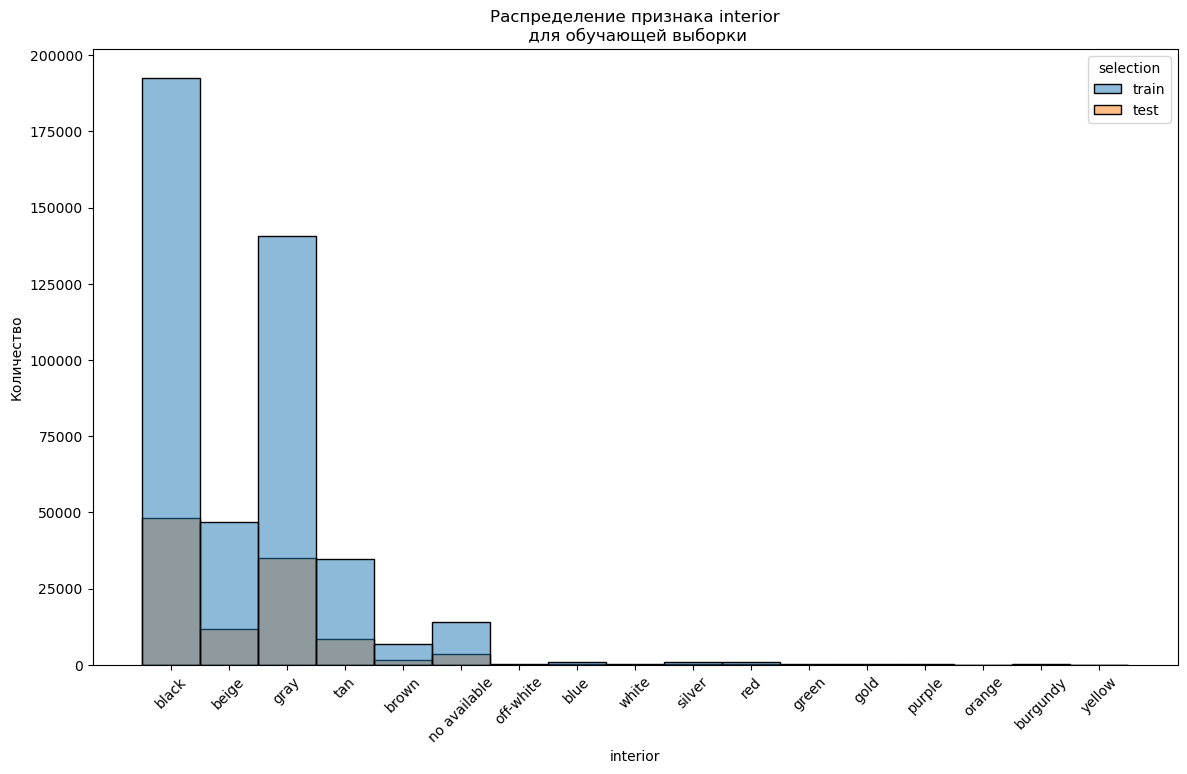

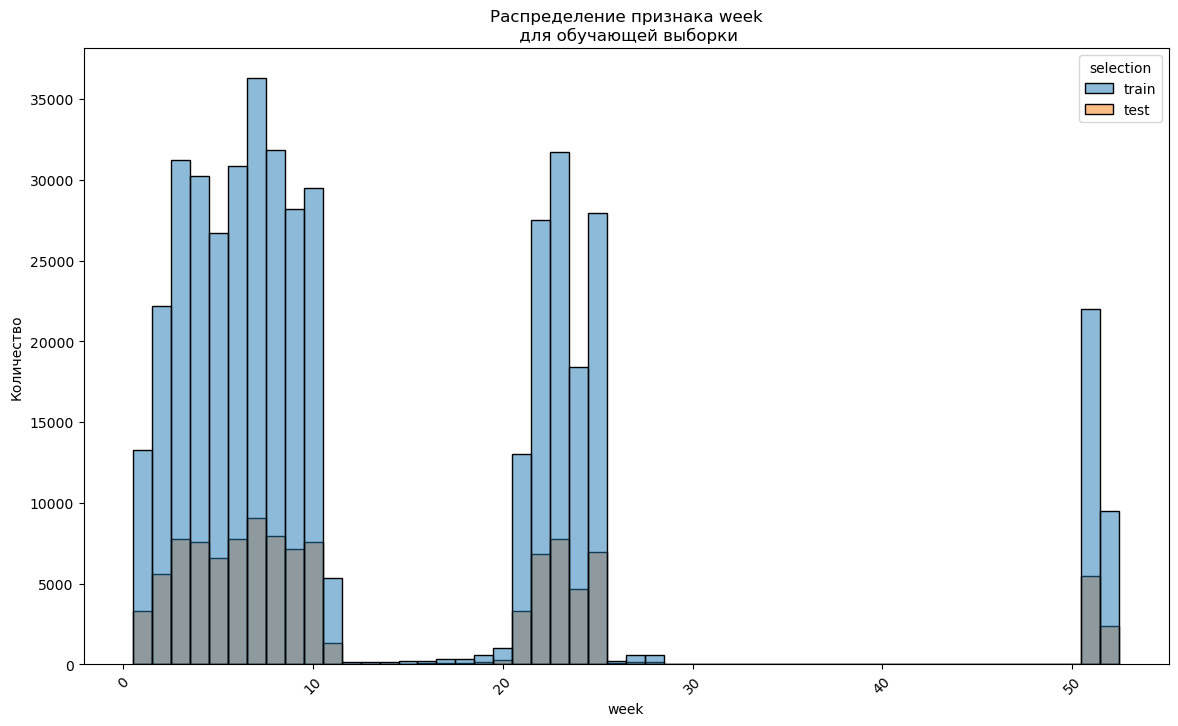

In [22]:
histogr(df_analysys)

**Вывод:**
1. Наиболее востребованы автомобили 2012-2014 годов выпуска.
2. Наиболее востребованная марка - ford.
3. Наиболее востребованные типы кузовов - sedan и suv.
4. Наиболее востребованная трансмиссия - automatic.
5. Наиболее востребованы автомобили, зарегистрированные в fl, ca, pa и tx.
6. Наиболее востребованы автомобили цвета black, white, silver и gray.
7. Наибольшее количество продаж - январь-февраль (недели 1-10), наименьшие - апрель, июль-ноябрь.

## Разработка модели ML
<a id="ML"></a>

### Подготовка данных
<a id="data_preparation"></a>

Задаем общий для всех моделей параметр random_state:

In [23]:
RAND_STATE = 42

Из обучающей выборки выделяем валидационную:

In [24]:
df_train = df_train.dropna()
list_for_predict = ['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
                    'condition', 'odometer', 'color', 'interior', 'week', 'seller']
features = df_train[list_for_predict]
target = df_train['sellingprice']
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=RAND_STATE)
features_train = features_train.reset_index(drop=True)
features_valid = features_valid.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)
features_test = df_test[list_for_predict]
features_test = features_test.reset_index(drop=True)

Разделям признаки на целевой, категориальные и количественные:

In [25]:
target = 'sellingprice'
categorical_features = ['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
                                                  'color', 'interior','seller', 'week']
numerical__features = ['condition', 'odometer']

### Построение модели прогнозирования
<a id="build_models"></a>

Функция подбора модели (CatBoostRegressor):

In [26]:
def choose_model(features_train, target_train):
    cv_all = 5
    
    def choose_model(params, model_type):  
        model = RandomizedSearchCV(model_type,
                                   param_distributions=params,
                                   random_state=RAND_STATE,
                                   cv=cv_all
                                   )
        model.fit(features_train, target_train)
        pred = model.best_estimator_.predict(features_valid)
        mape_valid = mean_absolute_percentage_error(target_valid, pred)
        return mape_valid, model.best_estimator_, model.best_params_

    params_cbr = {'learning_rate' : [i/100 for i in list(range(5, 10, 2))],
                  'depth' : list(range(8, 13, 2)),
                  'l2_leaf_reg': list(range(1, 8, 2))}


    mape_valid_cbr, best_model_cbr, best_params_cbr = choose_model(params_cbr,
                                                                   CatBoostRegressor(cat_features = categorical_features,
                                                                                     silent=True,
                                                                                     iterations = 1000,
                                                                                     loss_function = "RMSE",
                                                                                     eval_metric = "MAPE",
                                                                                     random_state=RAND_STATE))
    print('MAPE валидационной выборки: {}'.format(mape_valid_cbr))
    print('Параметры лучшей модели: {}'.format(best_params_cbr))
    
    return best_model_cbr

In [27]:
%%time
best_model = choose_model(features_train, target_train)

MAPE валидационной выборки: 0.17471020597613357
Параметры лучшей модели: {'learning_rate': 0.09, 'l2_leaf_reg': 1, 'depth': 12}
CPU times: total: 3d 4h 26min 6s
Wall time: 5h 44min 14s


## Предсказание на тестовой выборке
<a id="pred_test"></a>

Оцениваем модель на тостовой выборке и сохраняем результат предсказания в файл csv:

In [28]:
predict_test = best_model.predict(features_test)
df_final_test = pd.DataFrame({'vin' : df_test['vin'],
                              'sellingprice' : predict_test})
df_final_test.to_csv('write_to_csv.csv', encoding='utf-8', index=False)

**Вывод:**
1. В качестве модели применен CatBoostRegressor.  
2. При обучении модели использовались следующие признаки:  
- "year", "make", "model", "trim", "body", "transmission", "state", "color", "interior", "seller", "week" - категориальные;  
- "condition", "odometer" - числовые.  
- "sellingprice" - целевой.  
3. В качестве переменных рассматривались следующие параметры модели:  
- learning_rate: от 0.05 до 0.1 с шагом 2;  
- depth: от 8 до 13 с шагом 2;  
- l2_leaf_reg: от 1 до 8 с шагом 2;  
4. Параметры наилучшей модели:  
- 'learning_rate': 0.09;  
- 'l2_leaf_reg': 1;  
- 'depth': 12.  
5. MAPE валидационной выборки для лучшей модели: 0.15945959097185539.  

## Оценка значимости признаков
<a id="significance"></a>

Определяем веса признаков в стоимости автомобиля:

make            28.936555
body            18.381925
year            13.644672
model           12.809009
odometer        11.615419
condition        4.284985
interior         2.381717
state            2.317692
week             1.850484
transmission     1.255097
dtype: float64


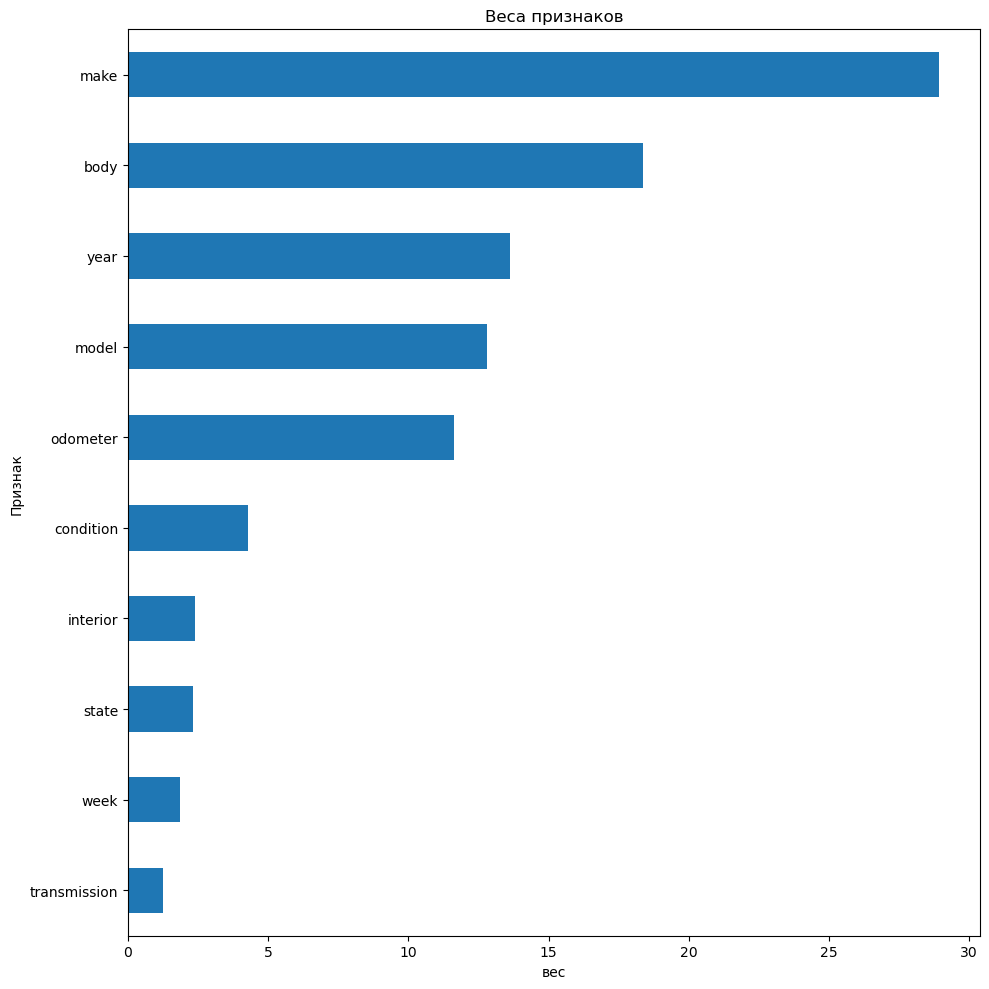

In [29]:
weight = (
    pd.Series(best_model.get_feature_importance(),features_train.columns)
    .sort_values()
    .tail(10)
)
print(weight.sort_values(ascending=False))
plt.figure(figsize=(10, 10))
weight.plot(kind='barh')
plt.title('Веса признаков')
plt.xlabel('вес')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

**Вывод:**  
Определяющий признак - "make" (бренд производителя).  
Также существенное влияние на цену имеют признаки:
- 'year' - год производства;
- 'odometer' - пробег в милях;
- 'trim' - модификация;
- 'model' - модель;

## Общий вывод
<a id="final"></a>

**Общая информация**  
1. В обучающей выборке 440236 строк и 15 признаков, в тестовой выборке 110060 строк и 14 признаков.  
2. В полях make, model, trim, body, transmission, condition, odometer, color, interior присутствуют пропущенные значения.  
2. Следующие признаки имеют тип int64:  
 - year;  
 - sellingprice.  
 
 Следующие признаки имеют тип object:  
  - make;  
  - model;  
  - trim;  
  - body;  
  - transmission;  
  - vin;  
  - state;  
  - color;  
  - interior;  
  - seller;  
  - saledate.   

 Следующие признаки имеют тип float64:  
  - condition;  
  - odometer.  
  
  
**Предобработка данных**  
1. Пропуски текстовых признаков заменены на "no available". Значения текстовых символов переведены в нижний регистр.  
2. Пропуски числовых значений заменены срезними значениями признаков в зависимости от года выпуска и модели автомобиля.  
3. Пропуски "transmission" заменены на наиболее часто встречающееся значения у соответствующих моделей автомобилей.  
4. Обработаны неявные дубликаты признаков "make', "model" и "body".  
5. Добавлен признак "week" - номер недели покупки автомобиля.  
6. Для признаков "trim" и "seller" оставлено 30 наиболее часто встречающихся значений. Остальные заменены на "no available".  


**Исследовательский анализ данных**  
1. Наиболее востребованы автомобили 2012-2014 годов выпуска.  
2. Наиболее востребованная марка - ford.  
3. Наиболее востребованные типы кузовов - sedan и suv.  
4. Наиболее востребованная трансмиссия - automatic.  
5. Наиболее востребованы автомобили, зарегистрированные в fl, ca, pa и tx.  
6. Наиболее востребованы автомобили цвета black, white, silver и gray.  
7. Наибольшее количество продаж - январь-февраль (недели 1-10), наименьшие - апрель, июль-ноябрь.  


**Разработка модели ML**
1. В чачестве модели применен CatBoostRegressor.  
2. При обучении модели использовались следующие признаки:  
- "year", "make", "model", "trim", "body", "transmission", "state", "color", "interior", "seller", "week" - категориальные;  
- "condition", "odometer" - числовые.  
- "sellingprice" - целевой.  
3. В качестве переменных рассматривались следуюие параметры модели:  
- learning_rate: от 0.05 до 0.1 с шагом 2;  
- depth: от 8 до 13 с шагом 2;  
- l2_leaf_reg: от 1 до 8 с шагом 2;  
4. Параметры наилучшей модели:  
- 'learning_rate': 0.09;  
- 'l2_leaf_reg': 1;  
- 'depth': 12.  
5. MAPE валидационной выборки для лучшей модели: 0.15945959097185539.  


**Оценка значимости признаков**  
Определяющий признак - "make" (бренд производителя).  
Также существенное влияние на цену имеют признаки:
- 'year' - год производства;
- 'odometer' - пробег в милях;
- 'trim' - модификация;
- 'model' - модель.